
# 🖐️ UI & Visualization Lab: The Hands (Interactive Senses)

Welcome to the Interaction Lab\! In this session, you will build the **"Hands"** of your Doner Detective. If Machine Learning is the **Brain** and the Database is the **Heart**, the **Hands** are the chart interface—they allow the user to reach out, touch the data, and interact with it.

We use **PySide6** and **Matplotlib** to build these "Hands," transforming the chart from a static image into a sensory system that reacts instantly to every move the user makes.

-----

## 🏗️ Phase 1: Component Architecture (The Building Blocks)

In `price_chart.py`, we define three core components to achieve interaction:


1.  **The Chart Body (The Muscles)**: **Purpose**: Transform raw database entries into visual representations that show how prices change over time.

**Implementation**: Using `ax.step()` with `where='post'` creates a "step plot" that reflects real-world price behavior—prices stay constant and then jump suddenly, rather than transitioning smoothly.

2.  **The Chart Style (The Skin)**: **Purpose**: Create visual harmony between the Matplotlib canvas and the PySide6 window frame.

**Technical Challenge**: QSS cannot style Matplotlib—it operates on a separate rendering engine. All styling must be done programmatically in Python.

3.  **Hover Labels (The Sense of Touch)**Purpose**: Provide instant feedback when users explore data points with their cursor.

**Mechanism**: Event-driven annotation system that appears at the cursor location and displays contextual information.


-----
## 📊 Phase 2: Visualization Theory (Why Step Plots?)

### 1\. The Mathematical Rationale

Real-world price data is **piecewise constant**:

$$
Price(t) = 
\begin{cases}
p_1 & \text{if } t_0 \leq t < t_1 \\
p_2 & \text{if } t_1 \leq t < t_2 \\
p_3 & \text{if } t_2 \leq t < t_3
\end{cases}
$$

### 2\. Linear Interpolation vs. Step Plot
  * **Linear Plot**: Suggests gradual price changes. Mathematically: $y(t) = y_1 + \frac{y_2-y_1}{t_2-t_1}(t-t_1)$
  * **Step Plot**: Preserves discontinuity. The price stays at $p_1$ until the exact moment of change at $t_1$.

### 3\. Real-world Example
If a Döner costs €5.50 on Monday and €6.00 on Friday:
  * A **line chart** would show €5.75 on Wednesday (incorrect—nobody paid this price)
  * A **step plot** correctly shows €5.50 Monday-Thursday, then jumps to €6.00 on Friday

-----

## 🎨 Phase 3: Styling Architecture (Two Separate Worlds)

Your application has two rendering engines working simultaneously:

| Engine | Styled By | Controls | Example |
|--------|-----------|----------|----------|
| **Qt (PySide6)** | `.qss` files | Window frame, buttons, panels | `QPushButton { background: #fff; }` |
| **Matplotlib** | Python code | Chart canvas, axes, lines | `ax.set_facecolor('#fdfbf7')` |

### 2\. Achieving Visual Harmony

To make the chart blend seamlessly with your vintage newspaper aesthetic:

In [8]:
# Set the figure background (outer container)
#fig = plt.subplots(figsize=(10, 6), facecolor='#fdfbf7')

# Set the axes background (inner plot area)
#ax.set_facecolor('#fdfbf7')

### 3\. Why QSS Cannot Control Matplotlib

  * **QSS** modifies the Qt widget tree using CSS-like selectors
  * **Matplotlib** renders to a pixel buffer, then embeds that buffer as a Qt widget
  * The styling must happen **before** the pixels are drawn, which QSS cannot access


## 🔄 Phase 4: Event-Driven Interaction (The Nervous System)

### 1\. The Event Loop Mechanism

In [9]:

#canvas.mpl_connect('motion_notify_event', on_hover)


This line establishes a **callback connection**:

  * **Event Source**: Matplotlib's event system monitors mouse coordinates
  * **Event Handler**: Your `on_hover()` function is called every time the mouse moves
  * **Response**: The annotation appears/disappears based on proximity to data points

  ### 2\. The Contains Algorithm

```python
cont, ind = line.contains(event)
```

This performs spatial proximity testing:

  * Calculates the distance from cursor $(x_c, y_c)$ to each data point $(x_i, y_i)$
  * Uses `pickradius` to define a "hit zone" around each point
  * Returns `True` and the index if within range

### 3\. The Reflex Response

When a point is detected:

1.  **Data Retrieval**: `index = ind["ind"][0]` identifies which row in the DataFrame
2.  **Coordinate Conversion**: `x_num = mdates.date2num(x_value)` converts datetime to plot coordinates
3.  **Annotation Update**: `annot.xy = (x_num, y_value)` repositions the label
4.  **Screen Refresh**: `fig.canvas.draw_idle()` redraws only changed elements

## 💻 Practical Implementation (Python Code Flow)

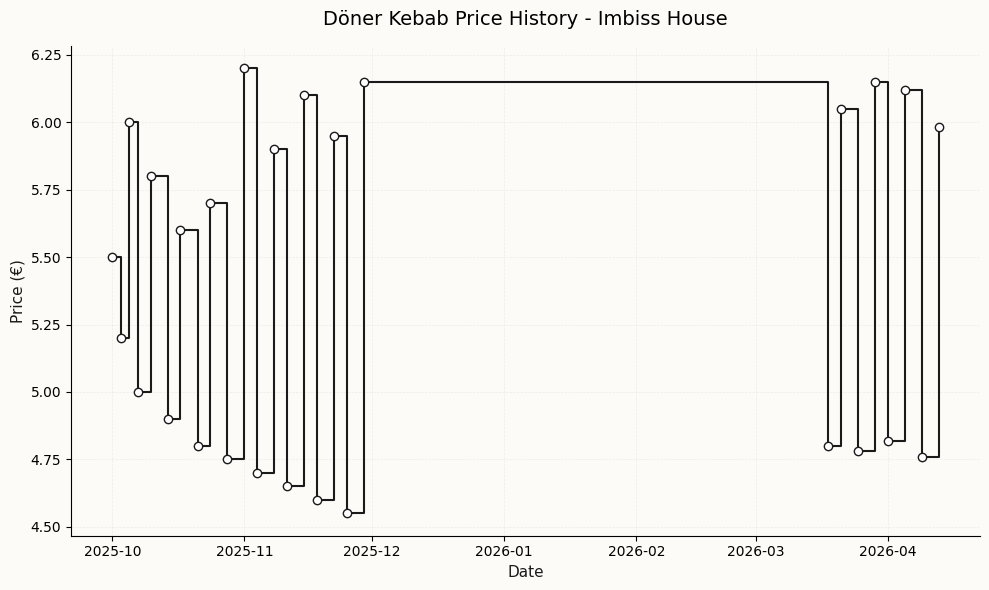

In [10]:

# ⚠️ IMPORTANT NOTE FOR STUDENTS:
# Interactive hover functionality requires a live event loop.
# Jupyter notebooks use a static rendering backend by default.
# 
# To see the hover effect in action:
# 1. Run the main application: python main.py
# 2. Search for any product (e.g., "Doner Kebab")
# 3. Move your mouse over the chart points!
# 
# The code below demonstrates the IMPLEMENTATION LOGIC,
# even though it won't be fully interactive in this notebook.


### Complete Interactive Chart Example


import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sys
import os

# ---------------------------------------------------------------------------
# PHASE 1: Database Connection (The Heart)
# ---------------------------------------------------------------------------
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)
import database

# Fetch historical price data from Supabase
df = database.get_prices_by_item_and_brand("Doner Kebab", "Imbiss House")

# ---------------------------------------------------------------------------
# PHASE 2: Chart Construction (The Muscles & Skin)
# ---------------------------------------------------------------------------
def setup_chart(ax, df):
    """
    Configures the chart with proper styling and data visualization.
    
    Args:
        ax: Matplotlib axes object
        df: DataFrame containing columns ['date', 'price', 'supermarket']
    
    Returns:
        line: The step plot Line2D object (needed for hover detection)
    """
    # Apply the vintage newspaper background color
    ax.set_facecolor('#fdfbf7')
    
    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if not df.empty:
        # Ensure datetime format and chronological order
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values(by='date')

        # Create the step plot with marker points
        # where='post' means the jump happens AFTER the x-value
        line, = ax.step(df['date'], df['price'], where='post',
                       color='#1a1a1a',        # Dark line color
                       marker='o',             # Circular markers
                       mfc='white',            # White marker fill
                       mec='#1a1a1a',          # Dark marker edge
                       picker=True,            # Enable pick events
                       pickradius=5)           # 5-pixel hit zone
        
        # Configure axes labels and formatting
        ax.set_xlabel('Date', fontsize=11, color='#1a1a1a')
        ax.set_ylabel('Price (€)', fontsize=11, color='#1a1a1a')
        ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)
        
        return line
    return None

# ---------------------------------------------------------------------------
# PHASE 3: Figure Initialization
# ---------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6), facecolor='#fdfbf7')
line = setup_chart(ax, df)

# Create the annotation object (initially hidden)
annot = ax.annotate("", xy=(0,0), xytext=(20,20), 
                    textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="white", ec="#1a1a1a", alpha=0.9),
                    arrowprops=dict(arrowstyle="->", color="#1a1a1a"),
                    fontsize=9)
annot.set_visible(False)

# ---------------------------------------------------------------------------
# PHASE 4: Event Handler (The Nervous System)
# ---------------------------------------------------------------------------
def on_hover(event):
    """
    Callback function triggered on mouse movement.
    Displays price information when hovering over data points.
    """
    # Check if mouse is inside the axes and we have data
    if event.inaxes == ax and line is not None:
        # Test for proximity to any data point
        cont, ind = line.contains(event)
        
        if cont:
            # ============================================================
            # STEP 1: Data Retrieval
            # ============================================================
            # Get the index of the closest point
            index = ind["ind"][0]
            
            # Retrieve the actual data from the DataFrame
            x_value = df.iloc[index]['date']
            y_value = df.iloc[index]['price']
            supermarket = df.iloc[index].get('supermarket', 'N/A')
            
            # ============================================================
            # STEP 2: Coordinate Transformation
            # ============================================================
            # Convert datetime to matplotlib's internal numeric format
            x_num = mdates.date2num(x_value)
            
            # Position the annotation at the data point
            annot.xy = (x_num, y_value)
            
            # ============================================================
            # STEP 3: Label Content
            # ============================================================
            # Format the display text
            date_str = x_value.strftime('%Y-%m-%d')
            annot.set_text(f"📅 {date_str}\n💰 {y_value:.2f}€\n🏪 {supermarket}")
            
            # ============================================================
            # STEP 4: Rendering
            # ============================================================
            annot.set_visible(True)
            fig.canvas.draw_idle()  # Efficient redraw
        else:
            # Mouse not near any point - hide annotation
            if annot.get_visible():
                annot.set_visible(False)
                fig.canvas.draw_idle()

# ---------------------------------------------------------------------------
# PHASE 5: Event Connection
# ---------------------------------------------------------------------------
# Register the hover callback with matplotlib's event system
fig.canvas.mpl_connect('motion_notify_event', on_hover)

# Final styling and display
plt.title("Döner Kebab Price History - Imbiss House", fontsize=14, pad=15)
plt.tight_layout()
plt.show()


## 🧪 Student Code Challenge: Build Your Own Interactive Chart

Now it's your turn! Complete the following exercises to solidify your understanding of interactive data visualization.

### Exercise 1: Database Integration

**Objective**: Connect to the database and fetch product price history.

**Skills Tested**: Module imports, function calls, data retrieval

In [11]:

# TODO: Import the correct database function
# Hint: Look at the database.py file for available functions
from ________ import ________

# TODO: Fetch data for "Oat Milk" from brand "Oaty"
# Store the result in a variable called 'df'
df = ________("Oat Milk", "Oaty")

# Verify your result:
# display(df)

# Expected output: DataFrame with columns ['id', 'item_name', 'date', 'weekday', 'price', 'supermarket', ...]


ModuleNotFoundError: No module named '________'

In [ ]:
%matplotlib inline  # Static display for notebooks

# NOTE FOR STUDENTS:
# Interactive hover doesn't work in all Jupyter environments.
# To see the hover effect in action:
# 1. Run the main application: python main.py
# 2. Search for any product
# 3. Hover over the chart points!
# 
# The code below shows HOW to implement hover logic,
# even though it won't be interactive in this notebook.


In [ ]:


import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sys
import os

# --- 1. The Heart (Connect to Data) ---
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)
import database

df = database.get_prices_by_item_and_brand("Oat Milk", "Oaty")

# --- 2. The Muscles & Skin (Define Plotting) ---
def setup_chart(ax, df):
    ax.set_facecolor('#fdfbf7')  # Apply the 'Skin' color
    
    if not df.empty:
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values(by='date')

        # Draw the Muscles (Step Plot)
        line, = ax.step(df['date'], df['price'], where='post',
                       color='#1a1a1a', marker='o', mfc='white',
                       picker=True, pickradius=5)
        return line
    return None

# --- 3. The Bone (EXECUTION) ---
fig, ax = plt.subplots(figsize=(10, 6), facecolor='#fdfbf7')
line = setup_chart(ax, df)

# Add the 'Senses' (The hidden label)
annot = ax.annotate("", xy=(0,0), xytext=(20,20), textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="white", ec="#1a1a1a"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

# --- 4. The Reflex (Hover Logic) ---
def on_hover(event):
    if event.inaxes == ax and line is not None:
        cont, ind = line.contains(event)
        if cont:
            # 1. THE TELEPORT: Get the actual data point from the DataFrame
            index = ind["ind"][0]
            
            # Get x, y coordinates from the DataFrame
            x_value = df.iloc[index]['date']
            y_value = df.iloc[index]['price']
            
            # Convert date to matplotlib format for positioning
            x_num = mdates.date2num(x_value)
            
            # Set annotation position
            annot.xy = (x_num, y_value)
            
            # 2. THE SIGN: Change the text to show the correct Price
            price = df.iloc[index]['price']
            supermarket = df.iloc[index].get('supermarket', 'N/A')
            annot.set_text(f"Price: {price:.2f}€\nStore: {supermarket}")
            
            # 3. THE REFLEX: Make it visible and refresh the screen
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            # If we stop touching, hide the sign
            annot.set_visible(False)
            fig.canvas.draw_idle()

# Connect the Nerves
fig.canvas.mpl_connect('motion_notify_event', on_hover)

plt.title("Oat Milk Price History", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price (€)")
plt.tight_layout()
plt.show()  # The final breath!

-----

## 🧪 Student Code Challenge: Try it Yourself\!

Now it's your turn\! Follow the steps below to complete the data loading and interaction logic.

### Step 1: Fetching Data from the Heart

**Task**: Import the correct function from `database.py` to get "Oat Milk" data.

In [ ]:
# TODO: Import the fetching function from database.py
from ________ import ________

# TODO: Call the function for "Oat Milk" and store it in df
df = ________("Oat Milk", "Oaty")

# to check your result --> 
# display(df)

### Exercise 2: Chart Styling

**Objective**: Apply visual styling to match the vintage newspaper aesthetic.

**Skills Tested**: Matplotlib styling methods, understanding of rendering engines

In [ ]:
def apply_vintage_style(ax):
    """
    Apply vintage newspaper styling to a matplotlib axes.
    
    TODO: Complete the missing method names
    """
    # Set the axes background to cream paper color
    # Hint: The method name describes what it 'sets' and what it colors (the 'face')
    ax.________('#fdfbf7')

    # Hide the top spine (border line)
    # Hint: Opposite of 'invisible'
    ax.spines['top'].________(False)
    
    # Hide the right spine
    ax.spines['right'].set_visible(False)
    
    # Optional: Make the remaining spines lighter
    ax.spines['left'].set_color('#cccccc')
    ax.spines['bottom'].set_color('#cccccc')

# Test your function:
# fig, ax = plt.subplots(facecolor='#fdfbf7')
# apply_vintage_style(ax)
# plt.show()

### Exercise 3: Event System Integration

**Objective**: Connect the hover event handler to the matplotlib event loop.

**Skills Tested**: Event-driven programming, callback functions


In [ ]:
# TODO: Fill in the correct event name
# Hint: This event fires when the mouse moves and wants to 'notify' us about 'motion'
# Check the matplotlib documentation or look at the complete example above

canvas.mpl_connect('_________', on_hover)

# Note: Interactive hover won't work in Jupyter notebooks,
# but understanding the event name is crucial for the main application!

# Common matplotlib events:
# - 'button_press_event'   : Mouse click
# - 'button_release_event' : Mouse release
# - 'motion_notify_event'  : Mouse movement
# - 'key_press_event'      : Keyboard press

### Exercise 4: Advanced Challenge - Smart Annotation Positioning

**Objective**: Prevent annotations from going off-screen by adjusting their offset dynamically.

**Skills Tested**: Coordinate systems, boundary detection, conditional logic

In [ ]:

def smart_annotation_position(event, annot, ax):
    """
    Adjust annotation offset based on cursor position to prevent off-screen labels.
    
    TODO: Complete the logic
    """
    # Get axes boundaries
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Calculate relative position (0 to 1)
    x_rel = (event.xdata - xlim[0]) / (xlim[1] - xlim[0])
    y_rel = (event.ydata - ylim[0]) / (ylim[1] - ylim[0])
    
    # TODO: If cursor is on the right half of the plot, show label on the LEFT
    # TODO: If cursor is on the top half of the plot, show label BELOW
    
    x_offset = ______  # Should be -20 if x_rel > 0.5, else 20
    y_offset = ______  # Should be -20 if y_rel > 0.5, else 20
    
    annot.set_position((x_offset, y_offset))

# This prevents labels from being cut off at the edges!



-----

## 🏁 Summary & Key Takeaways

### Core Concepts Mastered

1.  **Visualization Honesty**: The **Step Plot** (`ax.step()`) accurately represents discontinuous real-world data, unlike linear plots that interpolate between points.

2.  **Dual Rendering Engines**: Your application uses two separate systems:
      * **Qt/PySide6** (styled with `.qss`) for UI components
      * **Matplotlib** (styled with Python) for data visualization

3.  **Event-Driven Interaction**: Using `canvas.mpl_connect()` creates a "nervous system" that responds to user input in real-time.

4.  **Spatial Proximity Detection**: The `contains()` method performs geometric calculations to determine if the cursor is near a data point.

### Technical Skills Developed

  * **Database Integration**: Fetching and processing time-series data from Supabase
  * **Data Transformation**: Converting datetime objects to matplotlib coordinates
  * **Callback Functions**: Implementing event handlers for user interaction
  * **Annotation Systems**: Creating dynamic labels that follow cursor movement

### Connection to Machine Learning Lab

The visualization techniques learned here become crucial when displaying ML predictions:
  * The **step plot** can show actual prices vs. predicted prices side-by-side
  * **Hover annotations** can display prediction confidence intervals
  * **Event handlers** can trigger new predictions when users click on future dates

-----

## 🔗 Next Steps

To see the full interactive power of what you've built:
1.  Run `python main.py` from your project root
2.  Search for any product in the database
3.  Hover over the chart to see the annotations come alive!

**Remember**: The same principles you learned here apply to any data visualization task—from stock market charts to weather forecasts to machine learning dashboards.
